## Introduction
The two populations of students we are comparing here are males and females

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot as plt
from scipy.stats import invgamma
from scipy.stats import norm
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats.mstats import mquantiles as q
import warnings
warnings.filterwarnings('ignore')

## Prior Distributions

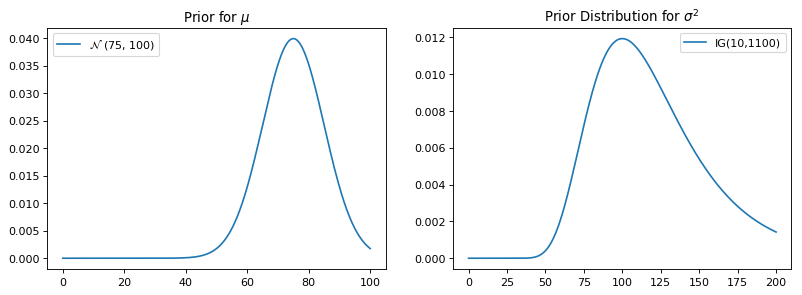

In [2]:
m = 75
v = 10**2
b = 20
fig=plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
x = np.linspace(0, 100, 1000)
title = "$\mathcal{N}$ " + f"({m}, {v})"
ax1.plot(x, norm.pdf(x, m, np.sqrt(v)), label=title)
ax1.set_title("Prior for $\mu$")
ax1.legend()
a = 10
b = 100*(a+1)
theta = 1/b
x = np.linspace(0, 200, 1000)
ax2.plot(x, invgamma.pdf(x, a, scale=b), label=f'IG({a},{b})')
ax2.set_title("Prior Distribution for $\sigma^{2}$")
ax2.legend()
plt.show()

## Data Visualization

In [3]:
student = pd.read_csv('StudentsPerformance.csv')
males = student[student['gender']=='male']
females = student[student['gender']=='female']

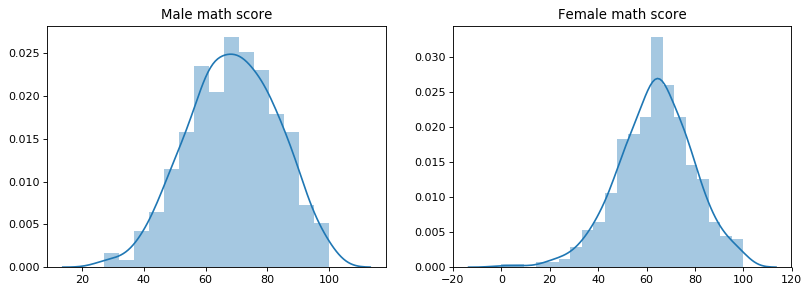

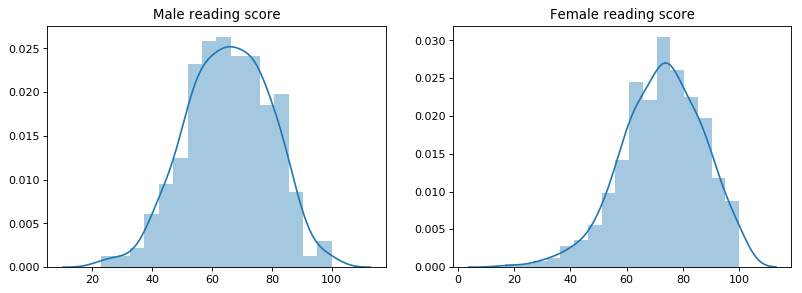

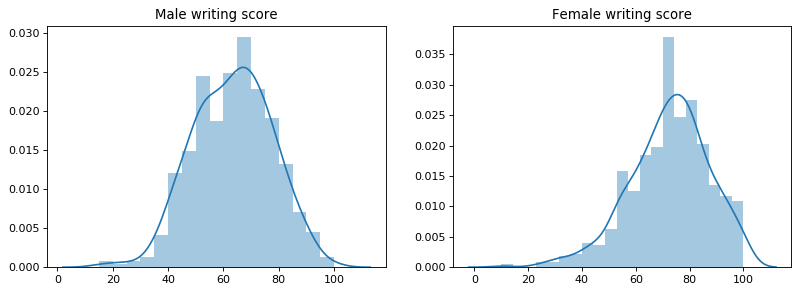

In [4]:
subjects = ['math score', 'reading score', 'writing score']
for i, sub in enumerate(subjects):
    fig=plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
    ax = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    title_m = "Male " + sub
    title_f = "Female " + sub
    sns.distplot(males[sub].values, ax=ax)
    ax.set_title(title_m)
    sns.distplot(females[sub].values, ax=ax2)
    ax2.set_title(title_f)
    plt.show()

## Functions

In [5]:
def post_params(data,N=10000):
    y = data.values
    y_bar = np.mean(y)
    mu = np.ones(N)
    mu[0] = 0
    sig2 = np.ones(N)
    n = len(y)
    sig2[0] = np.var(y)
    loop = tqdm(total=N, position=0, leave=False) 
    for j in range(2, N):
        loop.update(1)
        #update µ
        v_star = 1 / ((n/sig2[j-1]) + (1/v))
        m_star = v_star * ((n/sig2[j-1])*y_bar +(1/v)*m)
        mu[j] = np.random.normal(m_star, np.sqrt(v_star), 1) #in r it's rnorm(n=1, m_star, np.sqrt(v_star))

        #update sigma2
        a_star = 0.5*n +a
        b_star = .5*np.sum([(k - mu[j])**2 for k in y]) + b
        theta_star = 1/b_star #in python it wants the scale
        sig2[j] = 1/np.random.gamma(a_star, scale=theta_star, size=1)
    loop.close()
    
    return mu,sig2,y


In [6]:
def plots(mu,sig2,y,title,burnouts=100, gender="male"):
    c = 'Blues'
    if gender == 'female':
        c = 'RdPu'
    mut = '$\mu_{'+title+'}$'
    sigt = '$\sigma^2_{'+title+'}$'

    # Raw Convergence Plots
    fig=plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.plot(mu)
    ax1.set_title(mut)
    ax1.set_xlabel("Index")
    ax1.set_ylabel("$\mu$")
    ax2.plot(sig2)
    ax2.set_title(sigt)
    ax2.set_xlabel("Index")
    ax2.set_ylabel("$\sigma^2$")
    plt.show()


    # ACF Pre-Burnin
    fig=plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
    ax1 = plt.subplot(121)
    ax1.plot(acf(mu), color='r')
    plt.suptitle("ACF for "+mut)
    ax2 = plt.subplot(122)
    plot_acf(mu,ax=ax2, title='', use_vlines=True)
    ax1.set_xlabel("Lag")
    ax1.set_ylabel("ACF")
    ax2.set_xlabel("Lag")
    ax2.set_ylabel("ACF")
    plt.show()
    
    fig=plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
    ax1 = plt.subplot(121)
    ax1.plot(acf(sig2), color='g')
    plt.suptitle("ACF for "+sigt)
    ax2 = plt.subplot(122)
    plot_acf(sig2, ax=ax2, title='', use_vlines=True)
    ax1.set_xlabel("Lag")
    ax1.set_ylabel("ACF")
    ax2.set_xlabel("Lag")
    ax2.set_ylabel("ACF")
    plt.show()
    
    # ACF Post-Burnin
    fig=plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
    ax1 = plt.subplot(121)
    ax1.plot(acf(mu[0:-1:burnouts]), color='r')
    plt.suptitle("Burn-in ACF for "+ mut )
    ax2 = plt.subplot(122)
    plot_acf(mu[0:-1:burnouts],ax=ax2, title='', use_vlines=True)
    ax1.set_xlabel("Lag")
    ax1.set_ylabel("ACF")
    ax2.set_xlabel("Lag")
    ax2.set_ylabel("ACF")
    plt.show()
    
    fig=plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
    ax1 = plt.subplot(121)
    ax1.plot(acf(sig2[0:-1:burnouts]), color='g')
    plt.suptitle("Burn-in ACF for "+ sigt )
    ax2 = plt.subplot(122)
    plot_acf(sig2[0:-1:burnouts], ax=ax2, title='', use_vlines=True)
    ax1.set_xlabel("Lag")
    ax1.set_ylabel("ACF")
    ax2.set_xlabel("Lag")
    ax2.set_ylabel("ACF")
    plt.show()

    # Resulting Dist Plot
    fig=plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    sns.distplot(mu, ax=ax1, hist=False,label="Posterior for "+mut)
    ax1.plot(x, norm.pdf(x, m, np.sqrt(v)), label="Prior for "+mut)
    ax1.set_title("Prior and Posterior for "+mut)
    ax1.legend()

    q = np.linspace(0,300,301)
    sns.distplot(sig2,ax=ax2, hist=False,label="Posterior for "+sigt)
    ax2.plot(q, invgamma.pdf(q, a, scale=b), label="Prior for "+sigt)
    ax2.set_title("Prior and Posterior for "+sigt)
    ax2.legend()
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Density")
    ax2.set_xlabel("Value")
    ax2.set_ylabel("Density")
    plt.show()

    #3d Plots
    w2 = np.linspace(60,75,101)
    w = np.linspace(0,300,301)
    X,Y=np.meshgrid(w2,w)

    def f(x, y):
        return norm.pdf(x,np.mean(mu),np.sqrt(np.var(mu)))*invgamma.pdf(y, a, scale=b)

        

    fig = plt.figure(figsize=(15,10))


    X, Y = np.meshgrid(w2, w)
    Z = f(X, Y)

    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Y, X, Z,cmap=c)
    plt.title('Joint Bivariate Posterior Density for '+title)
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    ax.set_zlabel('z');
    plt.show()

    return X,Y,Z

In [7]:
def joints(X1,Y1,Z1,X2,Y2,Z2,lab):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    men = ax.plot_surface(Y1, X1, Z1,cmap='Blues')
    women = ax.plot_surface(Y2, X2, Z2,cmap='RdPu',alpha=0.4)
    cbar1 = plt.colorbar(men)
    cbar1.ax.set_ylabel('Males', rotation=270)
    cbar1.ax.set_yticklabels(['']) 
    cbar2 = plt.colorbar(women)
    cbar2.ax.set_ylabel('Females', rotation=270)
    cbar2.ax.set_yticklabels(['']) 
    plt.title('Joint Bivariate Posterior Density ' + lab)
    ax.set_xlabel('$\sigma^2$')
    ax.set_ylabel('$\mu$')
    ax.set_zlabel('z');
    plt.show()


## Posterior Distribution for Male Math Scores

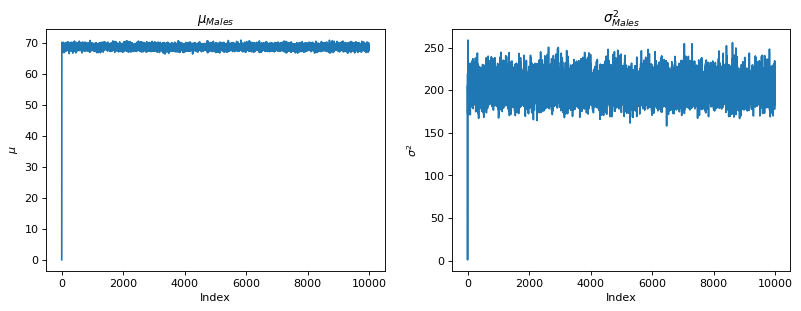

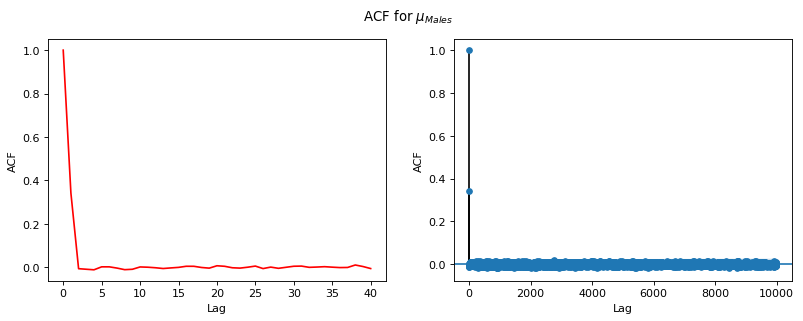

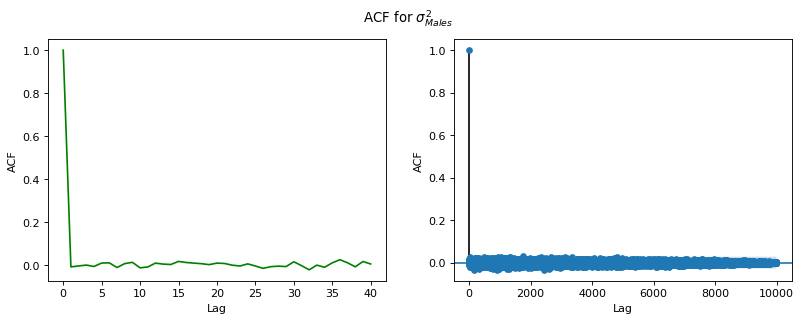

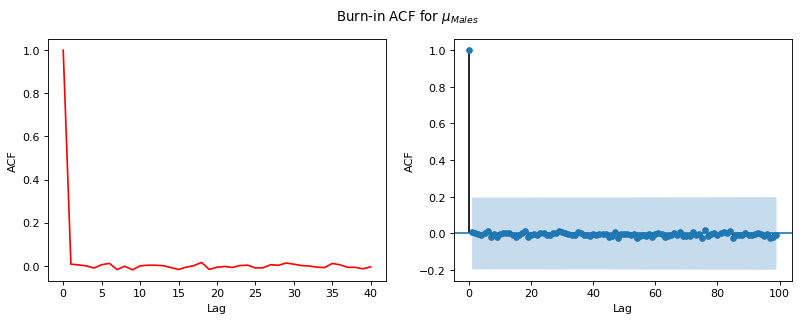

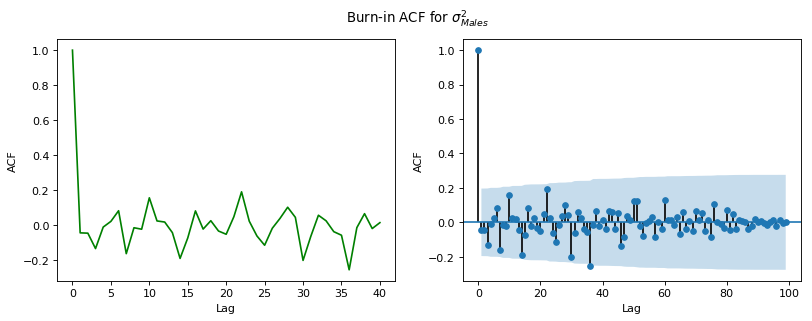

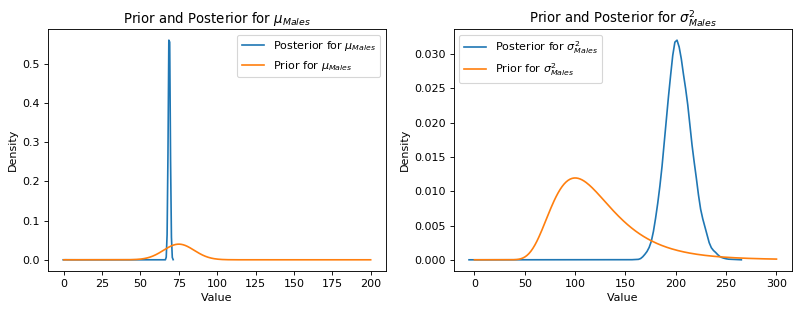

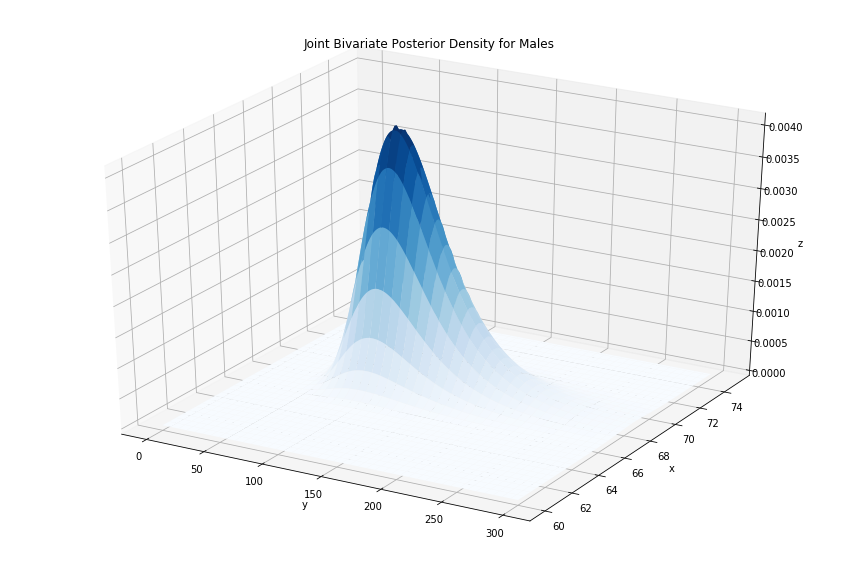

In [8]:
mu1,sig21,y = post_params(males['math score'],N=10000)
X1,Y1,Z1 = plots(mu1,sig21,y,'Males',burnouts=100)

## Posterior Distribution for Male Reading Scores

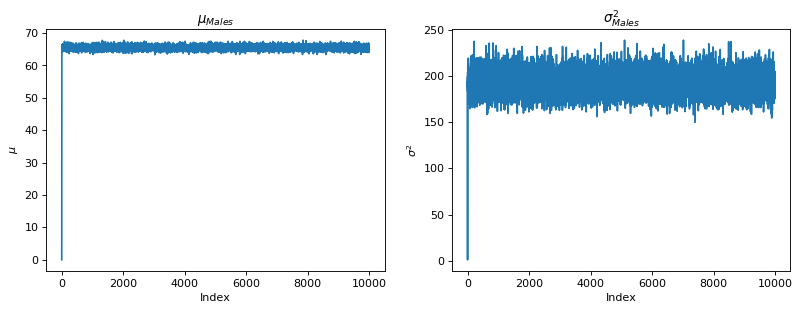

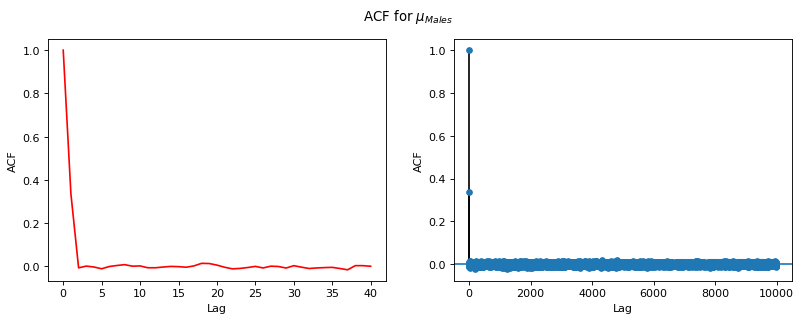

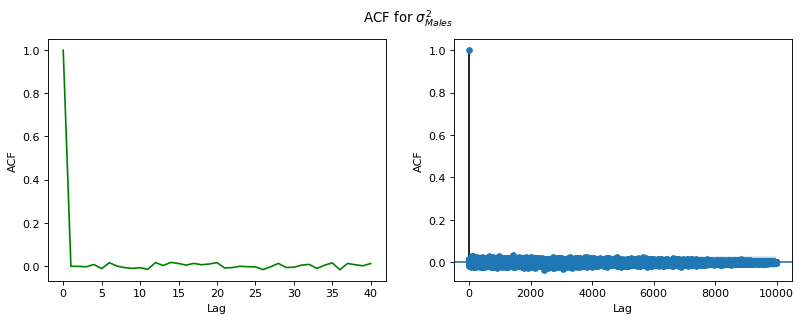

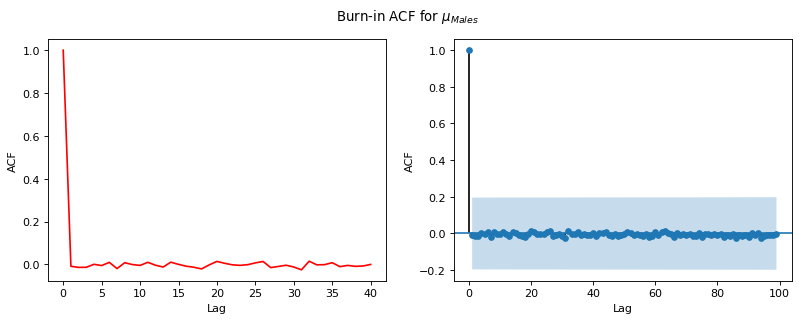

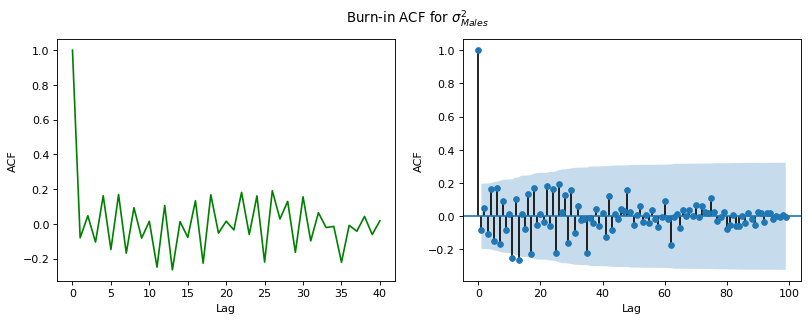

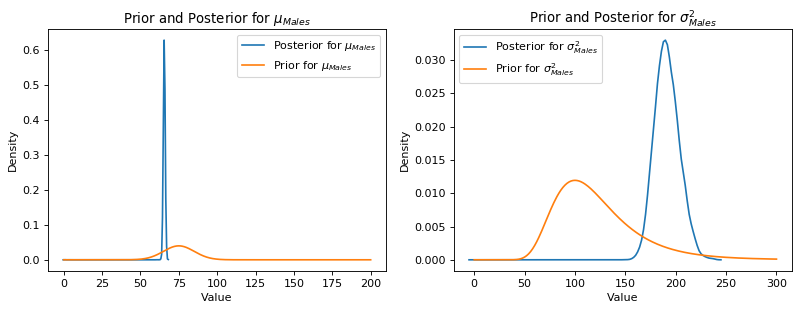

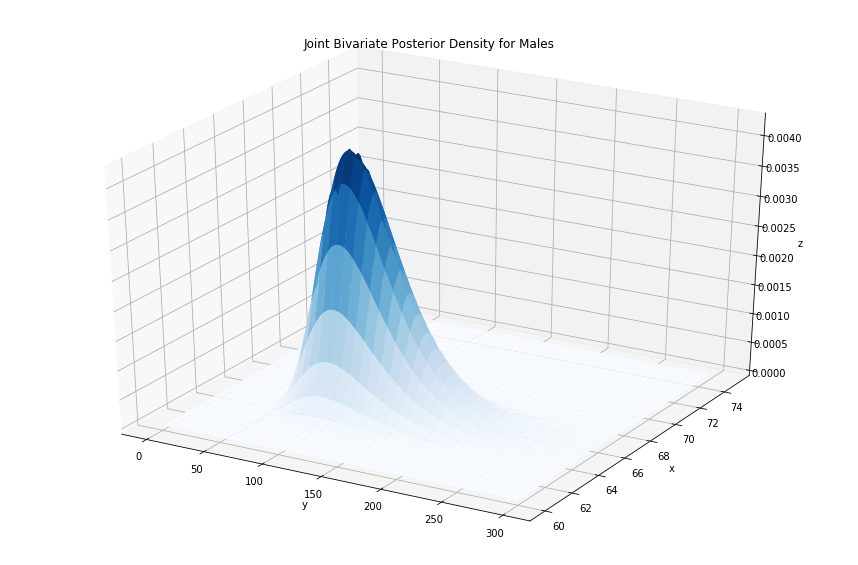

In [9]:
mu3,sig23,y = post_params(males['reading score'],N=10000)
X3,Y3,Z3 = plots(mu3,sig23,y,'Males',burnouts=100)

## Posterior Distribution for Male Writing Scores

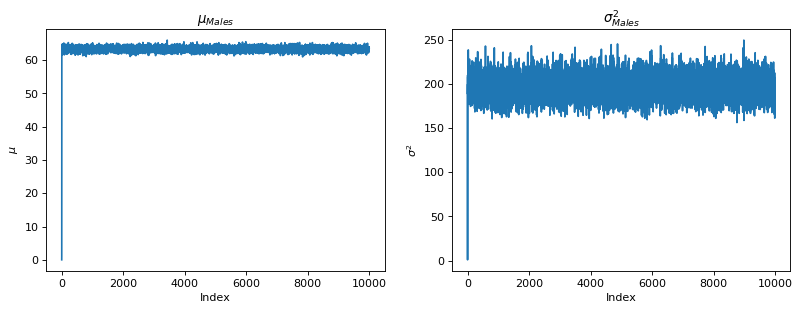

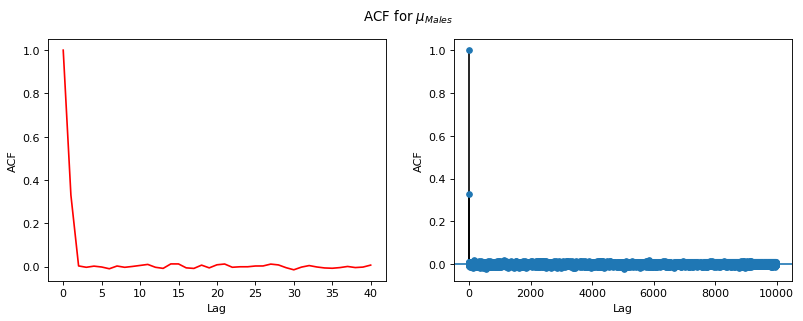

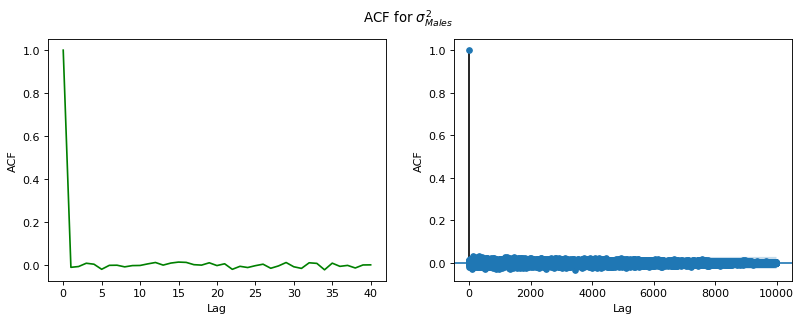

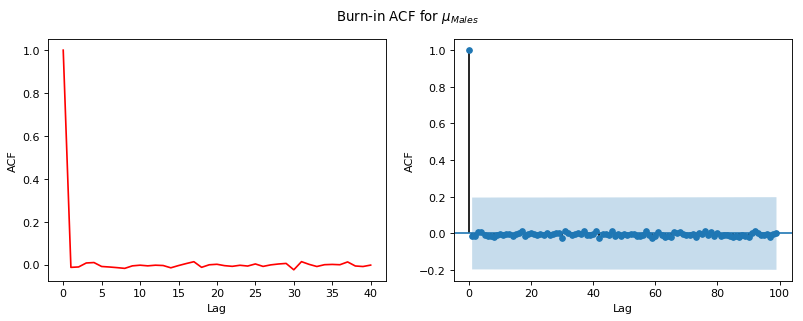

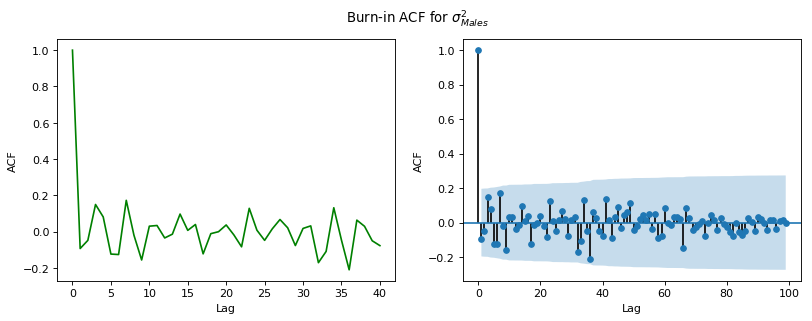

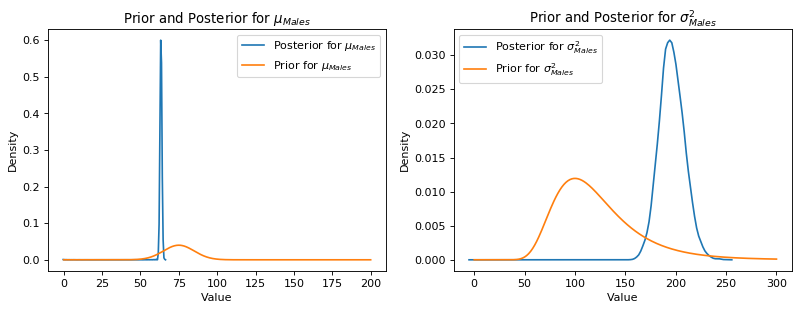

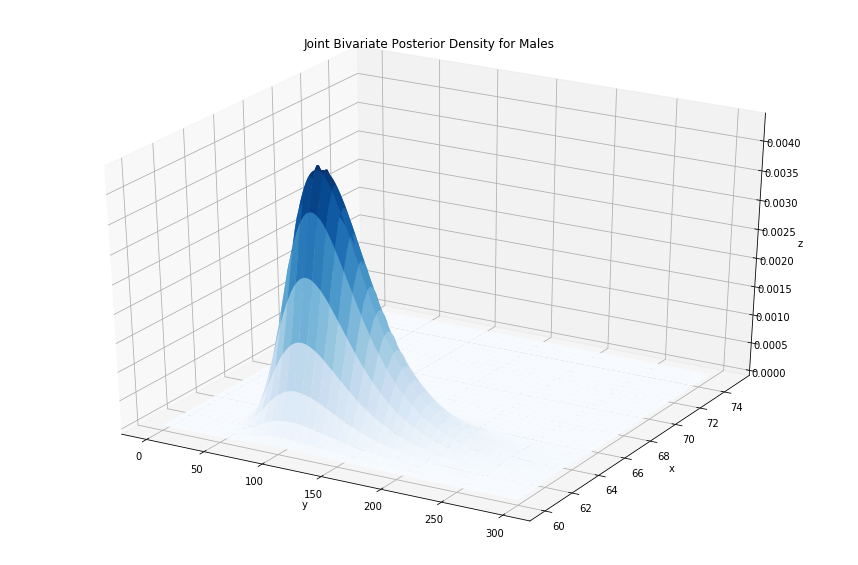

In [10]:
mu5,sig25,y = post_params(males['writing score'],N=10000)
X5,Y5,Z5 = plots(mu5,sig25,y,'Males',burnouts=100)

## Posterior Distribution for Female Math Scores

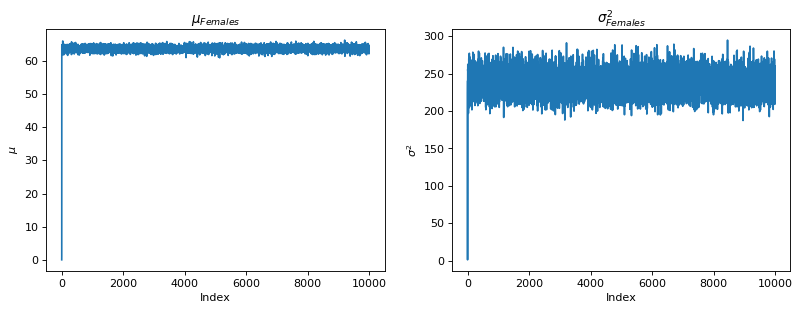

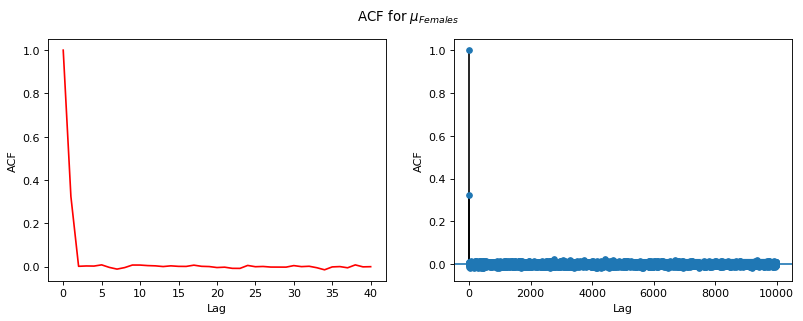

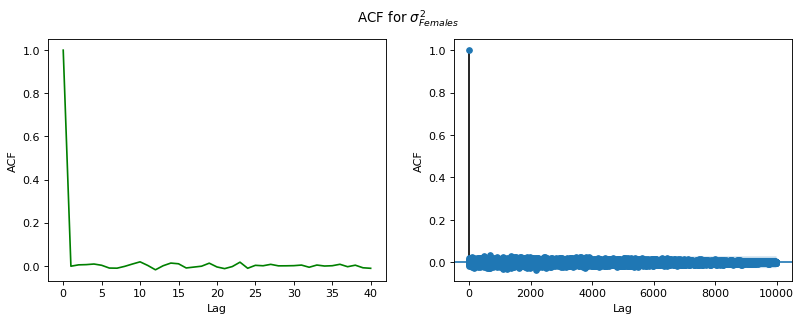

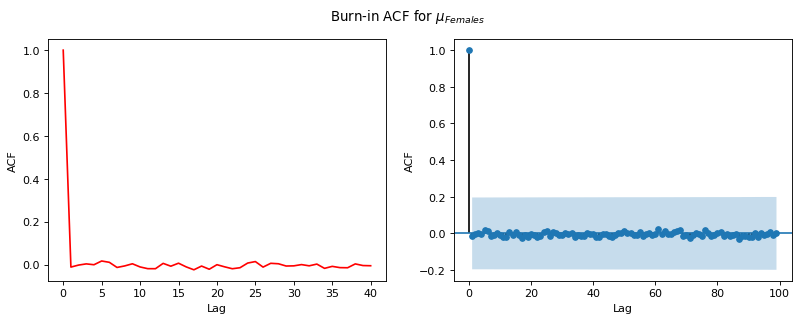

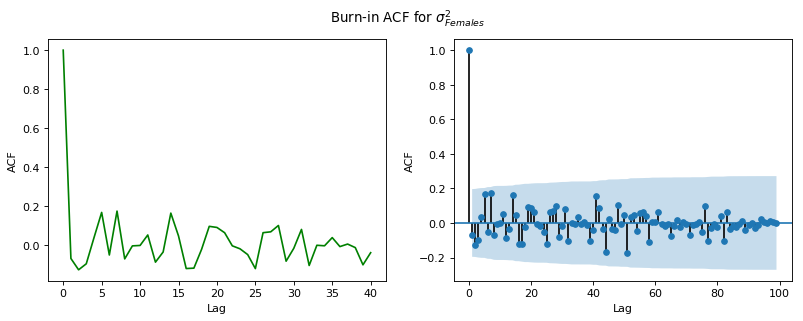

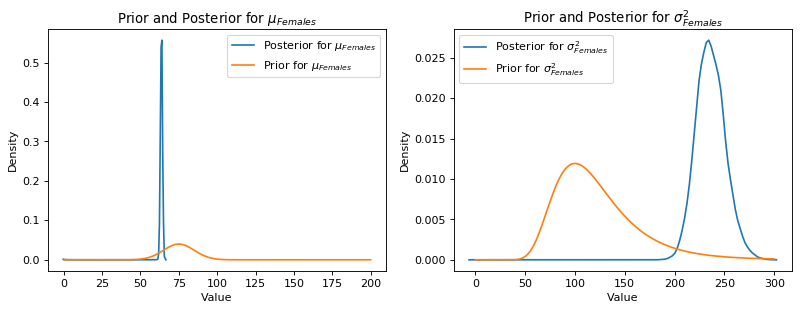

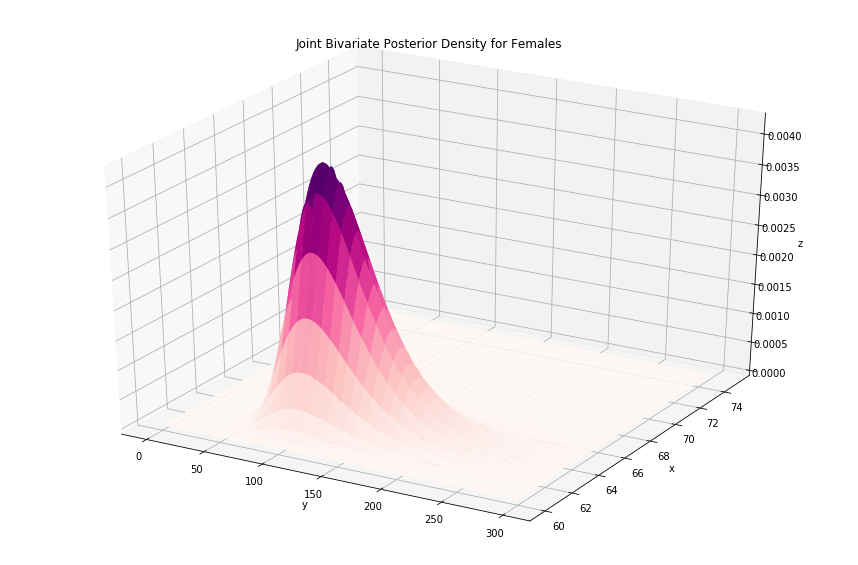

In [11]:
mu2,sig22,y = post_params(females['math score'],N=10000)
X2,Y2,Z2 = plots(mu2,sig22,y,'Females',burnouts=100, gender='female')

## Posterior Distribution for Female Reading Scores

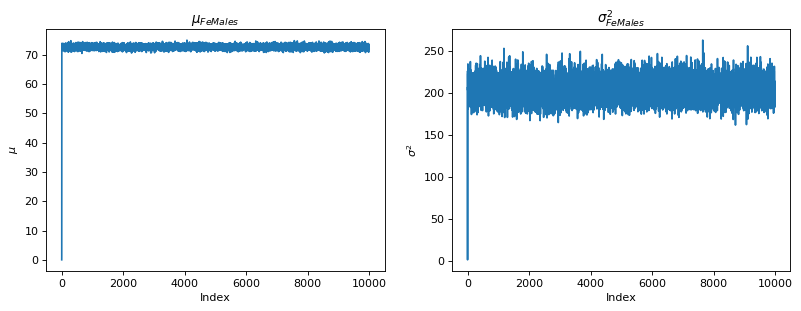

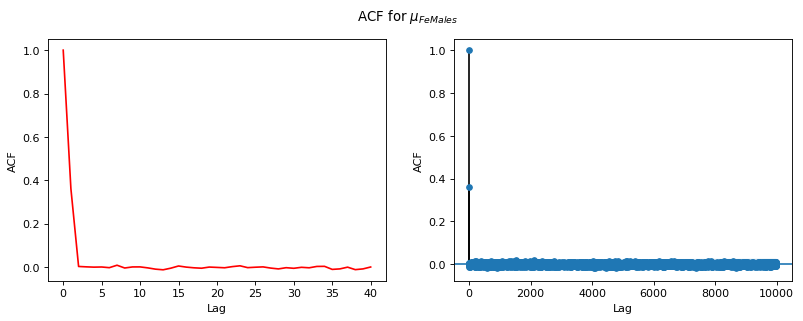

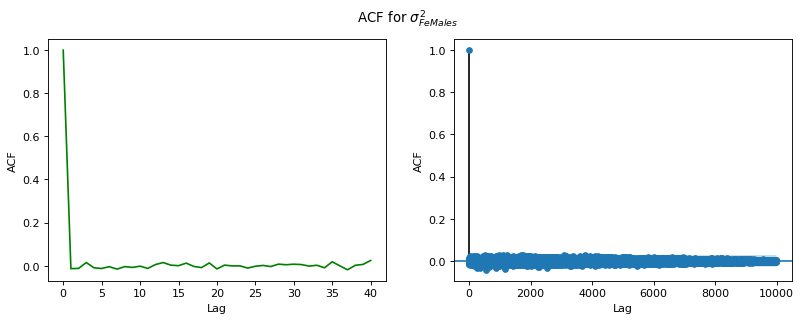

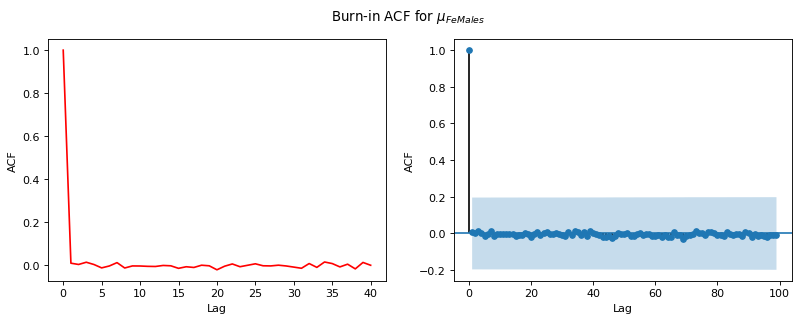

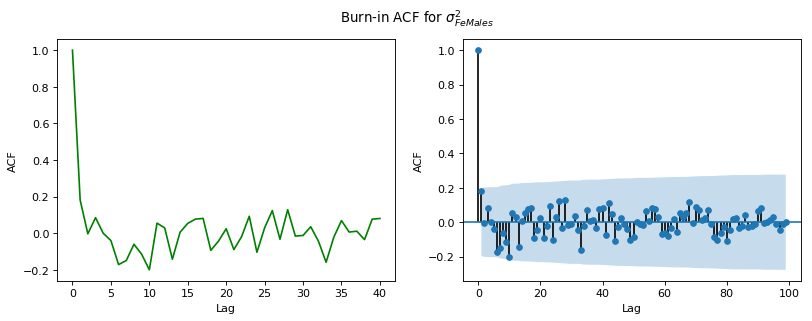

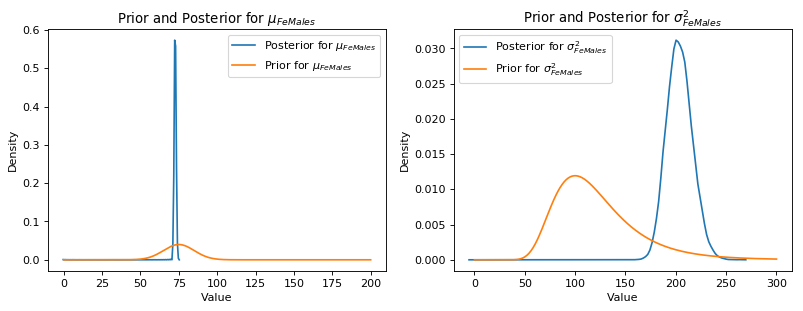

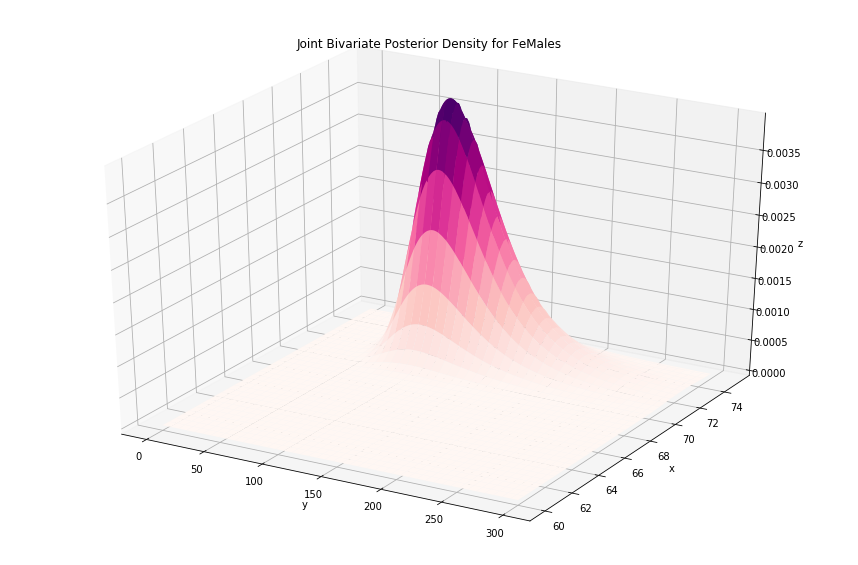

In [12]:
mu4,sig24,y = post_params(females['reading score'],N=10000)
X4,Y4,Z4 = plots(mu4,sig24,y,'FeMales',burnouts=100, gender='female')

## Posterior Distribution for Female Writing Scores

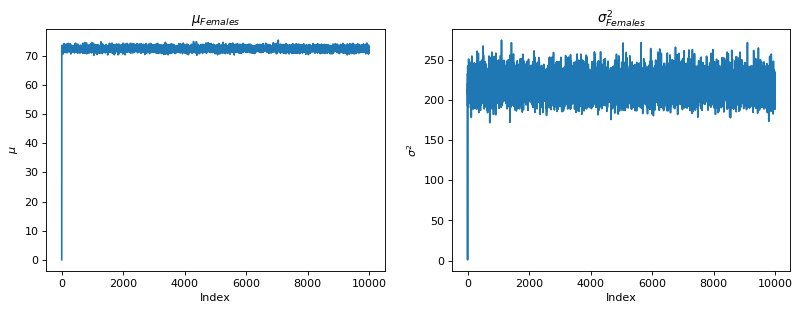

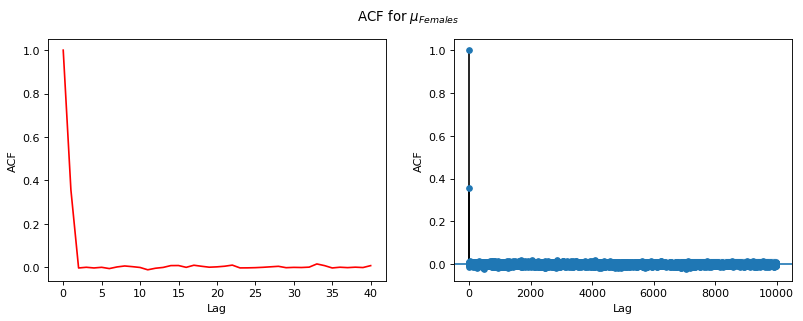

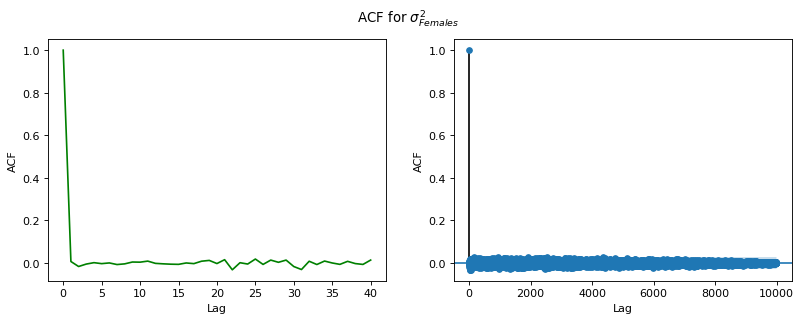

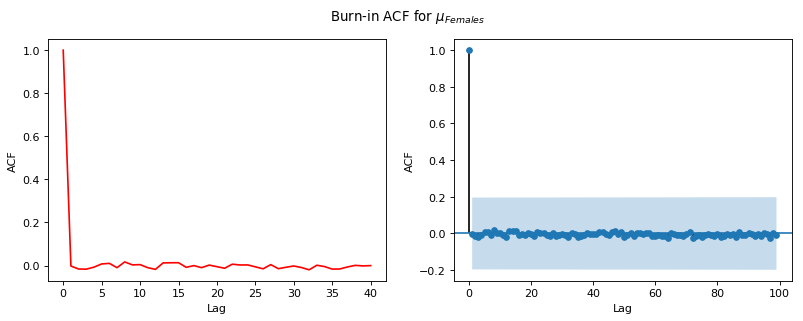

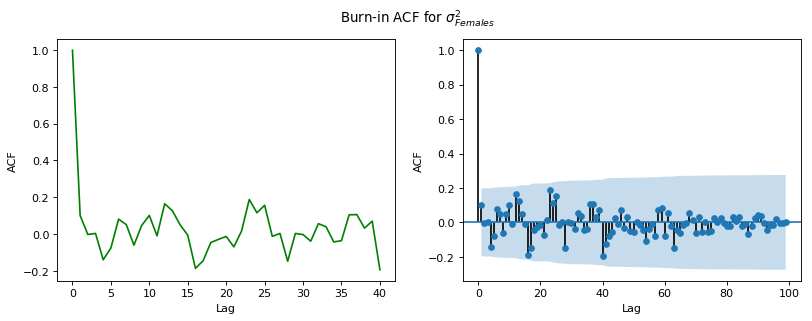

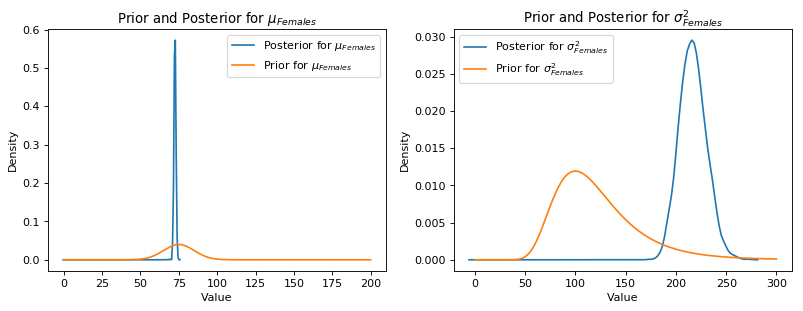

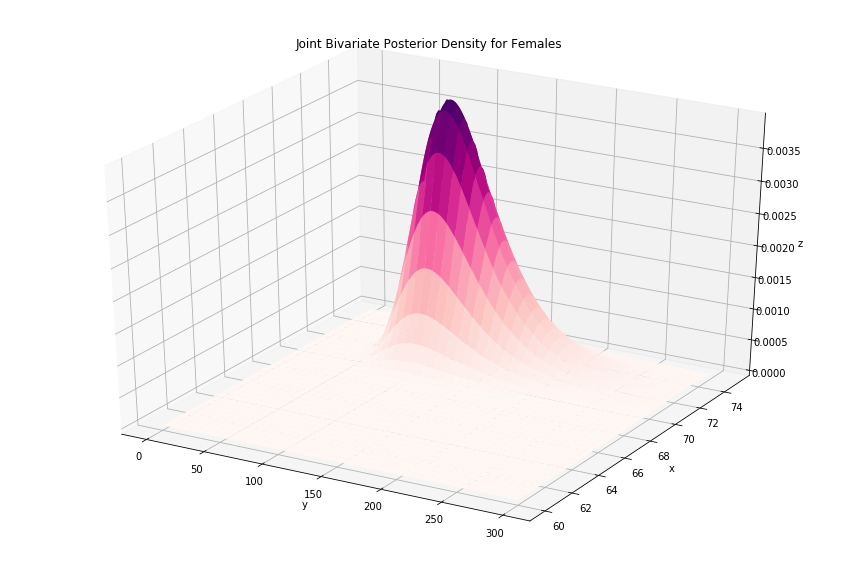

In [13]:
mu6,sig26,y = post_params(females['writing score'],N=10000)
X6,Y6,Z6 = plots(mu6,sig26,y,'Females',burnouts=100, gender='female')

## Comparing Posteriors 

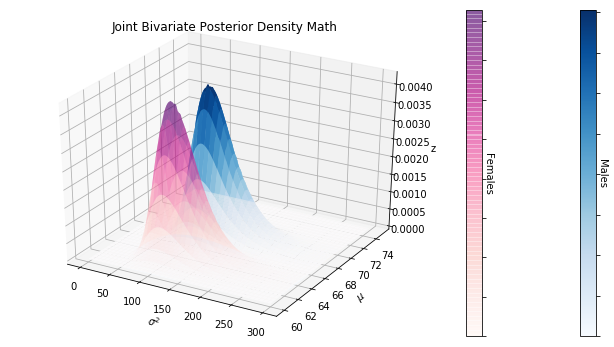

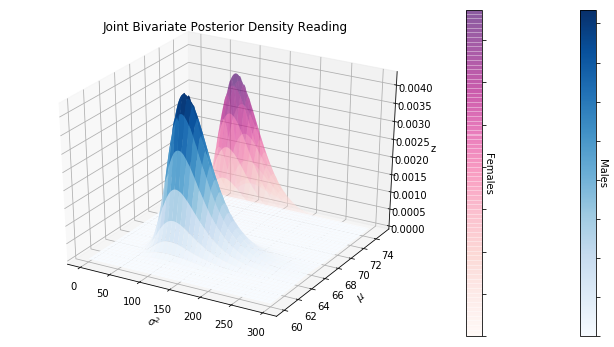

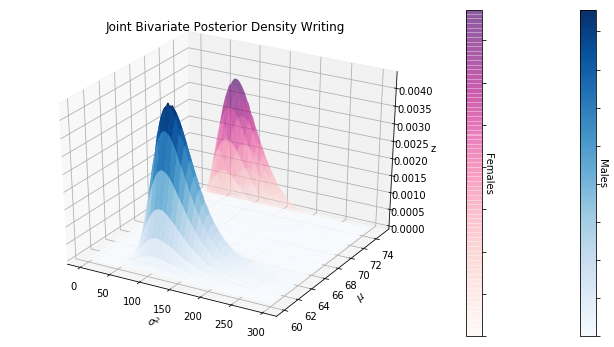

In [14]:
joints(X1,Y1,Z1,X2,Y2,Z2,lab='Math')
joints(X3,Y3,Z3,X4,Y4,Z4,lab="Reading")
joints(X5,Y5,Z5,X6,Y6,Z6,lab="Writing")

In [15]:
print("Mean math score for males:", round(np.mean(mu1),2))
print("Mean math score for females:", round(np.mean(mu2),2))

print("\nMean reading score for males:", round(np.mean(mu3),2))
print("Mean reading score for females:", round(np.mean(mu4),2))

print("\nMean writing score for males:", round(np.mean(mu5),2))
print("Mean writing score for females:", round(np.mean(mu6),2))


print("\nEstimated Pr(male math > female math) = ", np.mean(mu1 > mu2))
print("Estimated Pr(male reading ≥ male reading) = ", np.mean(mu3 >= mu4))
print("Estimated Pr(male writing ≥ male writing) = ", np.mean(mu5 >= mu6))

#95% credible interval for the difference between means
print("\n95% credible interval for (mean male math - mean female math) ", q(mu1[10:-1:100] - mu2[10:-1:100], [0.025, 0.975]))
print("95% credible interval for (mean male reading - mean female reading) ", q(mu3[10:-1:100] - mu4[10:-1:100], [0.025, 0.975]))
print("95% credible interval for (mean male writing - mean female writing) ", q(mu5[10:-1:100] - mu6[10:-1:100], [0.025, 0.975]))

#95% credible interval for the ratio of variances
print("\n95% credible interval for (variance male math ÷ mean female math) ", q(sig21[10:-1:100] / sig22[10:-1:100], [0.025, 0.975]))
print("95% credible interval for (variance male reading ÷ mean female reading) ", q(sig23[10:-1:100] / sig24[10:-1:100], [0.025, 0.975]))
print("95% credible interval for (variance male writing ÷ mean female writing) ", q(sig25[10:-1:100] / sig26[10:-1:100], [0.025, 0.975]))

Mean math score for males: 68.75
Mean math score for females: 63.67

Mean reading score for males: 65.51
Mean reading score for females: 72.61

Mean writing score for males: 63.34
Mean writing score for females: 72.47

Estimated Pr(male math > female math) =  0.9998
Estimated Pr(male reading ≥ male reading) =  0.0002
Estimated Pr(male writing ≥ male writing) =  0.0002

95% credible interval for (mean male math - mean female math)  [3.38655608 6.75520264]
95% credible interval for (mean male reading - mean female reading)  [-8.9920912  -5.43701653]
95% credible interval for (mean male writing - mean female writing)  [-10.56956012  -7.52849691]

95% credible interval for (variance male math ÷ mean female math)  [0.72369544 1.05667957]
95% credible interval for (variance male reading ÷ mean female reading)  [0.79968791 1.13586693]
95% credible interval for (variance male writing ÷ mean female writing)  [0.74316488 1.0870799 ]


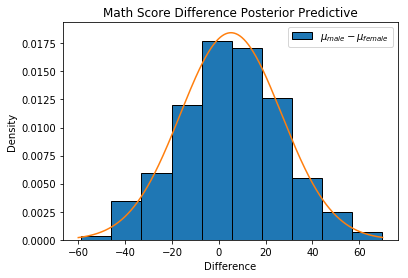

The probability that predicted value of male math scores is
greater than female math scores: 0.598


In [16]:
# Posterior predictive distributions
male_math_pred = np.random.normal(mu1[5:-1:10], np.sqrt(sig21[5:-1:10]))
female_math_pred = np.random.normal(mu2[5:-1:10], np.sqrt(sig22[5:-1:10]))
ppdiff = male_math_pred - female_math_pred

# Compute the probability that predicted value of bp for diabetic is
# greater that the predicted value of bp for non diabetic

x = np.linspace(-60,70,1000)
# display the predictive distribution
plt.hist(ppdiff,edgecolor='black', density=True, label="$\mu_{male}-\mu_{female}$")
plt.plot(x, norm.pdf(x, np.mean(ppdiff), np.sqrt(np.var(ppdiff))))
plt.title("Math Score Difference Posterior Predictive")
plt.xlabel("Difference")
plt.ylabel("Density")
plt.legend()
plt.show()

print("The probability that predicted value of male math scores is") 
print("greater than female math scores:", np.mean(ppdiff>0))


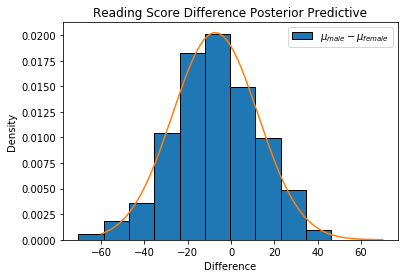

The probability that predicted value of male reading scores is
greater than female reading scores: 0.35


In [17]:
# Posterior predictive distributions
male_reading_pred = np.random.normal(mu3[5:-1:10], np.sqrt(sig23[5:-1:10]))
female_reading_pred = np.random.normal(mu4[5:-1:10], np.sqrt(sig24[5:-1:10]))
ppdiff = male_reading_pred - female_reading_pred

# Compute the probability that predicted value of bp for diabetic is
# greater that the predicted value of bp for non diabetic

x = np.linspace(-60,70,1000)
# display the predictive distribution
plt.hist(ppdiff,edgecolor='black', density=True, label="$\mu_{male}-\mu_{female}$")
plt.plot(x, norm.pdf(x, np.mean(ppdiff), np.sqrt(np.var(ppdiff))))
plt.title("Reading Score Difference Posterior Predictive")
plt.xlabel("Difference")
plt.ylabel("Density")
plt.legend()
plt.show()

print("The probability that predicted value of male reading scores is")
print("greater than female reading scores:", np.mean(ppdiff>0))


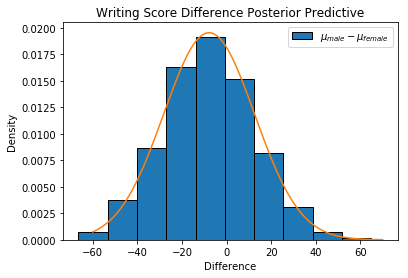

The probability that predicted value of male writing scores is
greater than female writing scores: 0.347


In [18]:
# Posterior predictive distributions
male_write_pred = np.random.normal(mu5[5:-1:10], np.sqrt(sig25[5:-1:10]))
female_write_pred = np.random.normal(mu6[5:-1:10], np.sqrt(sig26[5:-1:10]))
ppdiff = male_write_pred - female_write_pred

# Compute the probability that predicted value of bp for diabetic is
# greater that the predicted value of bp for non diabetic

x = np.linspace(-60,70,1000)
# display the predictive distribution
plt.hist(ppdiff,edgecolor='black', density=True, label="$\mu_{male}-\mu_{female}$")
plt.plot(x, norm.pdf(x, np.mean(ppdiff), np.sqrt(np.var(ppdiff))))
plt.title("Writing Score Difference Posterior Predictive")
plt.xlabel("Difference")
plt.ylabel("Density")
plt.legend()
plt.show()

print("The probability that predicted value of male writing scores is")
print("greater than female writing scores:", np.mean(ppdiff>0))

